# 🔍 Superstore Dataset Statistical Analysis Report
---

## Abstract
This report builds upon a previous analysis of the Superstore dataset, originally explored through Power BI dashboards. While the initial insights were based on patterns and visuals, this time the goal is to put those assumptions to the test using statistical methods.

The main focus is to understand whether discounts are truly hurting profits, to identify problematic product subcategories and regions, and to explore customer behavior more deeply. By combining clear visualizations with data-backed techniques, this report aims to give a more solid and trustworthy foundation for decision-making.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import date
from scipy.stats import mode
import warnings

# 1. Display only 4 decimals globally
pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(precision=4, suppress=True)

# 2. Suppress warnings (e.g., from plotting libraries)
warnings.filterwarnings('ignore')

# 3. Set max columns displayed
pd.set_option('display.max_columns', 100)

#Make plots look better
plt.style.use('seaborn-v0_8')

In [3]:
df['order date'] = pd.to_datetime(df['order date'])
df['ship date'] = pd.to_datetime(df['ship date'])
df['Year'] = df['order date'].dt.year
df['Month'] = df['order date'].dt.month
df['Month_name'] = df['order date'].dt.month_name()

df = df.rename(columns={'order date': 'Order Date', 'ship date': 'Ship Date'})


## 1. Discoun t Impact Analysis

### T-test Analysis Discounted vs Non-Discounted (Mean Profit)

In [ ]:
## T-test to compare means of profit between Discount vs Non-Discount
from scipy.stats import ttest_ind
discounted = df[df['Discount'] > 0]
non_discounted = df[df['Discount'] == 0]

t_stat_discount, p_value_discount = ttest_ind(discounted['Profit'], non_discounted['Profit'], equal_var=False)
print(f"T-statistic (Discounted vs Non-Discounted): {t_stat_discount}, P-value: {p_value_discount}\nThe Discounted group has a significantly lower mean profit compared to the Non-Discounted group.\n")

T-statistic (Discounted vs Non-Discounted): -15.562910120788137, P-value: 6.653553418425365e-54
 The Discounted group has a significantly lower mean profit compared to the Non-Discounted group.



## 2. Seasonal Sales Trend Analysis



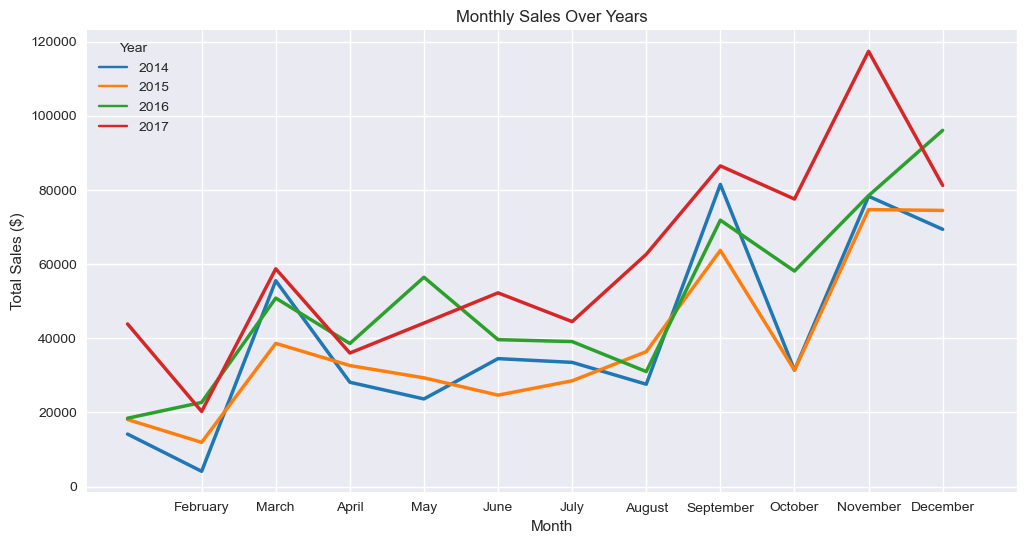

In [290]:
# Convert 'Month_name' to a categorical type with the correct order

df['Month_name'] = pd.Categorical(df['Month_name'], categories=month_order, ordered=True)
monthly_sales = df.groupby(['Year', 'Month_name'])['Sales'].sum().reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 6)) 
sns.lineplot(data=monthly_sales, x='Month_name', y='Sales', hue='Year', palette='tab10', linewidth=2.5)
plt.title('Monthly Sales Over Years')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(np.arange(1, 13))
plt.legend(title='Year')
plt.grid(True)
plt.show()


### Anova Test for Seasonal Variation

In [281]:
from scipy.stats import f_oneway 

# Serparate sales by month
month_groups = [group['Sales'].values for name, group in df.groupby('Month_name')]

# Perform ANOVA test
f_stat, p_value = f_oneway(*month_groups)
print(f"F-statistic: {f_stat}, P-value: {p_value}")
print()
print("This suggests there is no significant difference in sales between months.\nThe observed variation is likely driven by the number of transactions (sales volume), rather than changes in the average sale value.")

F-statistic: 1.142337968144262, P-value: 0.32281538534961757

This suggests there is no significant difference in sales between months.
The observed variation is likely driven by the number of transactions (sales volume), rather than changes in the average sale value.


The number of transactions per month appears to be correlated with total sales, supporting the idea that sales volume directly impacts total revenue.


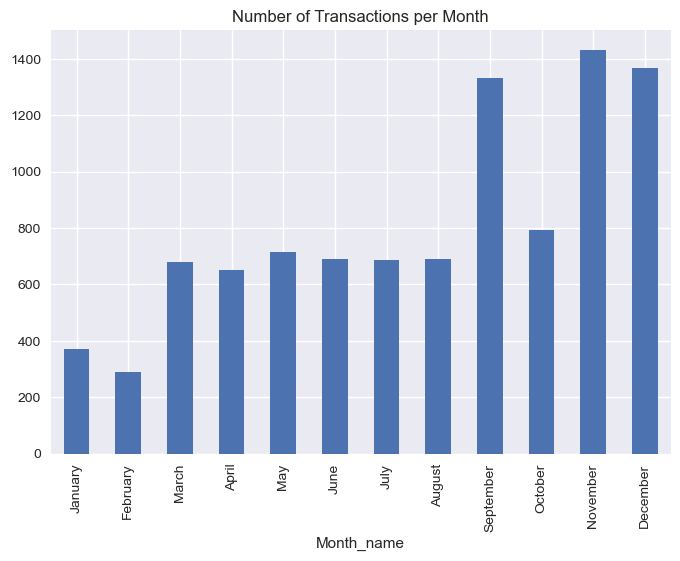

In [65]:
monthly_counts = df['Month_name'].value_counts().sort_index()
monthly_counts.plot(kind='bar', title='Number of Transactions per Month')
print('The number of transactions per month appears to be correlated with total sales, supporting the idea that sales volume directly impacts total revenue.')

In [283]:
monthly_stats = df.groupby('Month_name').agg({
    'Sales': 'sum',
    'Order ID': 'count'  # Or any column with 1 row per transaction
}).rename(columns={'Sales': 'Total_Sales', 'Order ID': 'nTransactions'}).round(2)

Sales_quantity_corr =monthly_stats['Total_Sales'].corr(monthly_stats['nTransactions']).round(2)

print(f'With a correlation of {Sales_quantity_corr} we can confirm that seasonal differences in sales amounts are primarily due to fluctuations in the number of transactions.') 
print()
print(monthly_stats)

With a correlation of 0.98 we can confirm that seasonal differences in sales amounts are primarily due to fluctuations in the number of transactions.

            Total_Sales  nTransactions
Month_name                            
January      94539.3400            370
February     59012.8300            290
March       203719.2600            679
April       135387.3600            651
May         153513.3100            715
June        151039.4300            692
July        145623.8500            686
August      157642.2500            689
September   303536.6700           1332
October     198440.0000            794
November    348834.5600           1430
December    321161.0000           1366


## 3.Customer Profitability Segmentation (K-Means)

In [280]:
customer_df = df.groupby('Customer ID').agg({
    'Sales' : 'sum',
    'Profit' : 'sum',
    'Discount' : 'mean'
}).reset_index().round(3)

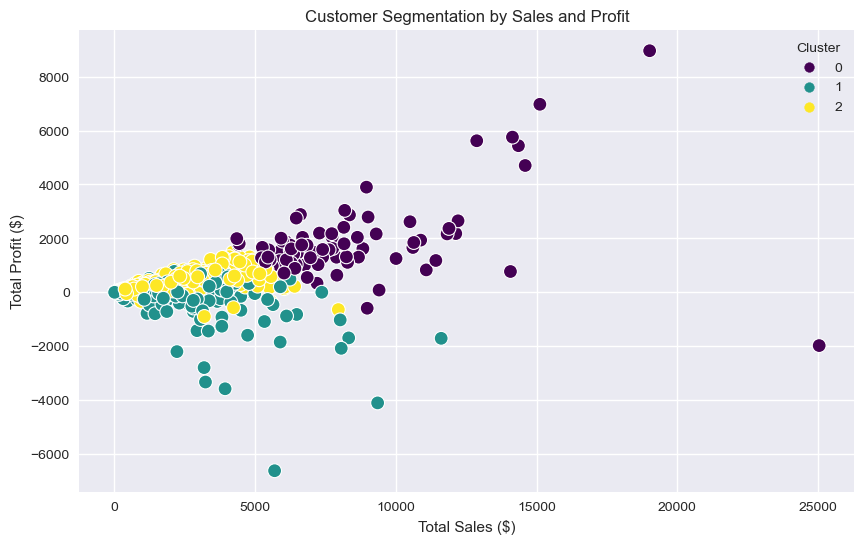

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# We scale the data before applying K-means
features = ['Sales', 'Profit', 'Discount']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_df[features])

# We conduct KMeans
kmeans = KMeans(n_clusters=3,random_state=42)  
customer_df['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters
plt.figure(figsize=(10, 6))     
sns.scatterplot(data=customer_df, x='Sales', y='Profit', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segmentation by Sales and Profit')
plt.xlabel('Total Sales ($)')
plt.ylabel('Total Profit ($)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### Cluster Interpretation

In [87]:
# Group by cluster and calculate mean values
cluster_summary = customer_df.groupby('Cluster').agg({
    'Sales': 'mean',
    'Profit': 'mean',
    'Discount': 'mean',
    'Customer ID': 'count' 
}).rename(columns={'Customer ID': 'Customer Count', 'Sales' : 'Mean_Sales', 'Profit' : 'Mean_Profit', 'Discount' : 'Mean_Discount'}).reset_index().round(2)

print(cluster_summary)
print()
cluster_summary_sum = customer_df.groupby('Cluster').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'sum',
    'Customer ID': 'count' 
}).rename(columns={'Customer ID': 'Customer Count', 'Sales' : 'Sum_Sales', 'Profit' : 'Sum_Profit', 'Discount' : 'Sum_Discount'}).reset_index().round(2)
# Calculate customer %
total_customers = customer_df['Customer ID'].nunique()
cluster_summary_sum['Customer%'] = (cluster_summary_sum['Customer Count'] / total_customers * 100)
print(cluster_summary_sum)


   Cluster  Mean_Sales  Mean_Profit  Mean_Discount  Customer Count
0        0   8217.1400    1855.4300         0.1200              86
1        1   2162.1000     -96.2300         0.2500             288
2        2   2250.8200     360.3900         0.1000             419

   Cluster   Sum_Sales  Sum_Profit  Sum_Discount  Customer Count  Customer%
0        0 706674.0300 159567.3800       10.4500              86    10.8449
1        1 622683.5100 -27713.9500       70.7900             288    36.3178
2        2 943092.3200 151004.3000       42.5600             419    52.8373


Cluster 0
-  High-Value, High-Profit, Low-Volume Customers. Despite being the smallest group their profit is the highest.

Cluster 1 
- Negative-Profit, High-Discount Customers. This group abuses of discounts and low the profits.

Cluster 2 
- Core Customer Base. The largest cluster moderately profitable and delivering stable and consistent revenue.

## Segment-Level Analysis: Products Purchased and Discount Trends 

### Cluster 0 - High-Value Customers

In [294]:
df_with_cluster[df_with_cluster['Cluster'] == 0]['Row ID'].count()

1528

 Profitable customers buy produtcts with high profit and low discount like Copiers, Binders, Maschines and Phones.



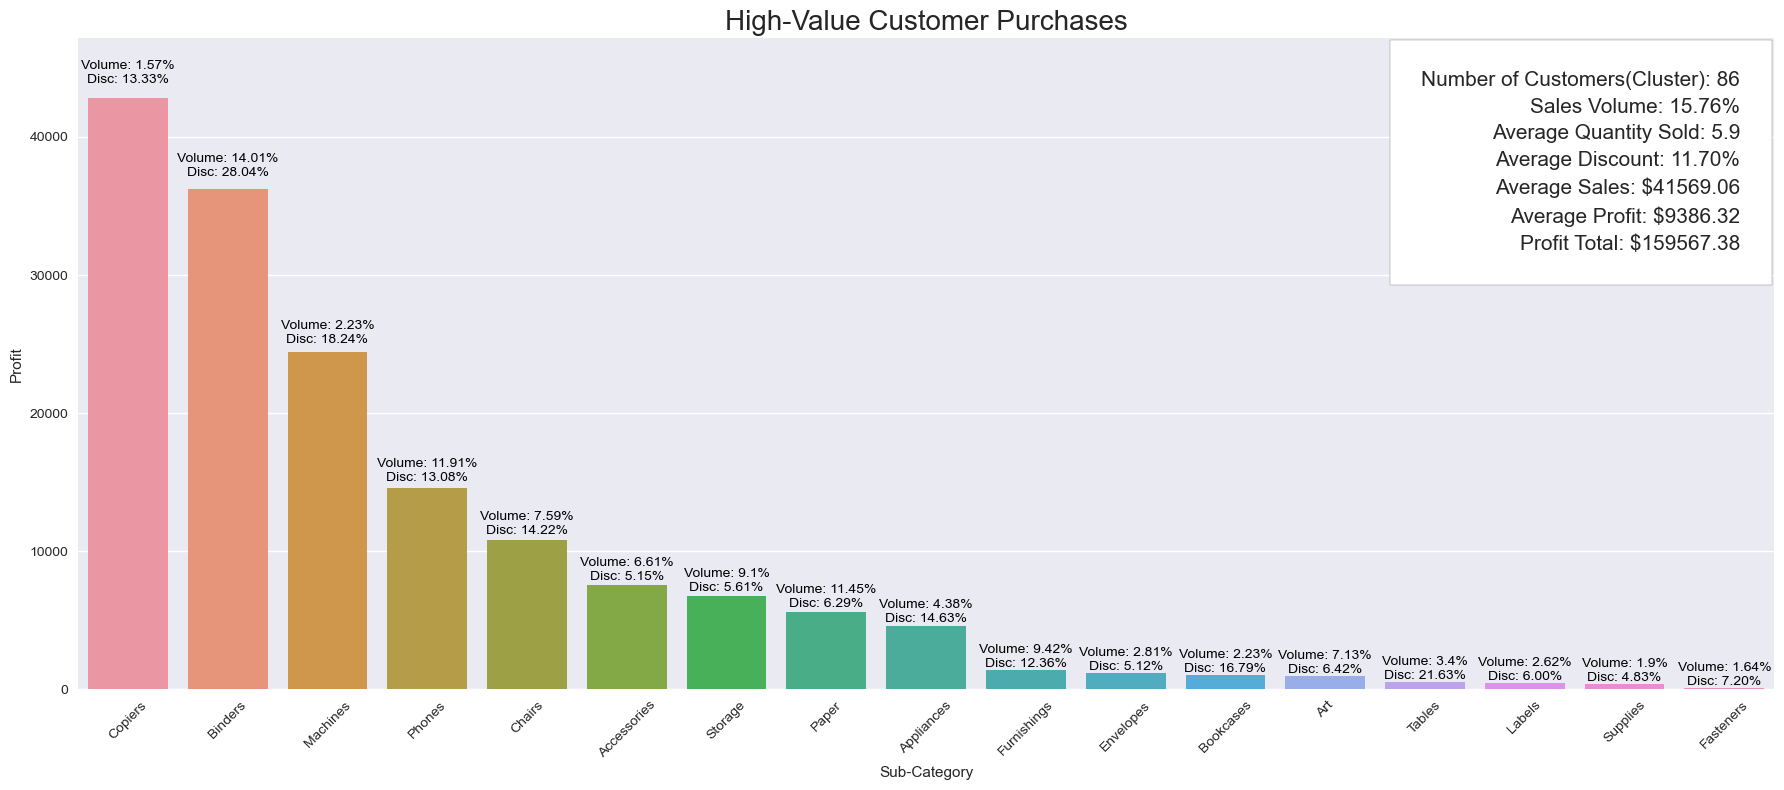

In [303]:
#df_with_cluster = df.merge(customer_df[['Customer ID', 'Cluster']], on='Customer ID', how='left')

High_value_customer = df_with_cluster[df_with_cluster['Cluster'] == 0].groupby('Sub-Category').agg({
    'Profit': 'sum',
    'Sales': 'sum',
    'Discount': 'mean',
    'Order ID': 'count'
}).rename(columns={'Order ID' : 'Salescount'}).reset_index().sort_values(by='Profit', ascending=False)
plt.figure(figsize=(18, 8))

Sales_volume = len(df_with_cluster[df_with_cluster['Cluster'] == 0])
High_value_customer['Sales_volume'] = (High_value_customer['Salescount'] / Sales_volume * 100).round(2)


ax = sns.barplot(data=High_value_customer, x='Sub-Category', y='Profit')


for i, bar in enumerate(ax.patches):     
    Sales_pct = High_value_customer.iloc[i]['Sales_volume']
    discount = High_value_customer.iloc[i]['Discount']

    text = f'Volume: {Sales_pct}%\nDisc: {discount:.2%}'

    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.02 * abs(height)),  
        text,
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )



# Crear "recuadro" con medias del DataFrame
mean_quantity = High_value_customer['Sales_volume'].mean()
mean_discount = High_value_customer['Discount'].mean()
mean_sales = High_value_customer['Sales'].mean()
mean_profit = High_value_customer['Profit'].mean()
n_customers = df_with_cluster[df_with_cluster['Cluster'] == 0]['Customer ID'].nunique()
sum_profit = df_with_cluster[df_with_cluster['Cluster'] == 0]['Profit'].sum()
sum_sales = df_with_cluster[df_with_cluster['Cluster'] == 0]['Sales'].sum()
sales_volume = len(df_with_cluster[df_with_cluster['Cluster'] == 0]) / len(df) *100

info_text = (
    f"Number of Customers(Cluster): {n_customers}\n"
    f"Sales Volume: {sales_volume:.2f}%\n"
    f"Average Quantity Sold: {mean_quantity:.1f}\n"
    f"Average Discount: {mean_discount:.2%}\n"
    f"Average Sales: ${mean_sales:.2f}\n"
    f"Average Profit: ${mean_profit:.2f}\n"
    f"Profit Total: ${sum_profit:.2f}"
)

# Añadir recuadro en la esquina superior derecha
plt.text(
    x=0.98, y=0.95,
    s=info_text,
    transform=ax.transAxes,
    fontsize=15,
    verticalalignment='top',
    horizontalalignment='right',
    linespacing=1.5,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=1.5')
)


plt.title('High-Value Customer Purchases', fontsize = 20)
plt.xticks(rotation=45)
plt.ylim(top=High_value_customer['Profit'].max() * 1.10)

print(" Profitable customers buy produtcts with high profit and low discount like Copiers, Binders, Maschines and Phones.\n")
plt.tight_layout()
plt.show()

### Cluster 1 - Negative-Profit Customers

Unprofitable customers buy products with high discount and low profit like Machines, Binders, Tables and Bookcases .
Which have a discount of more than 30%


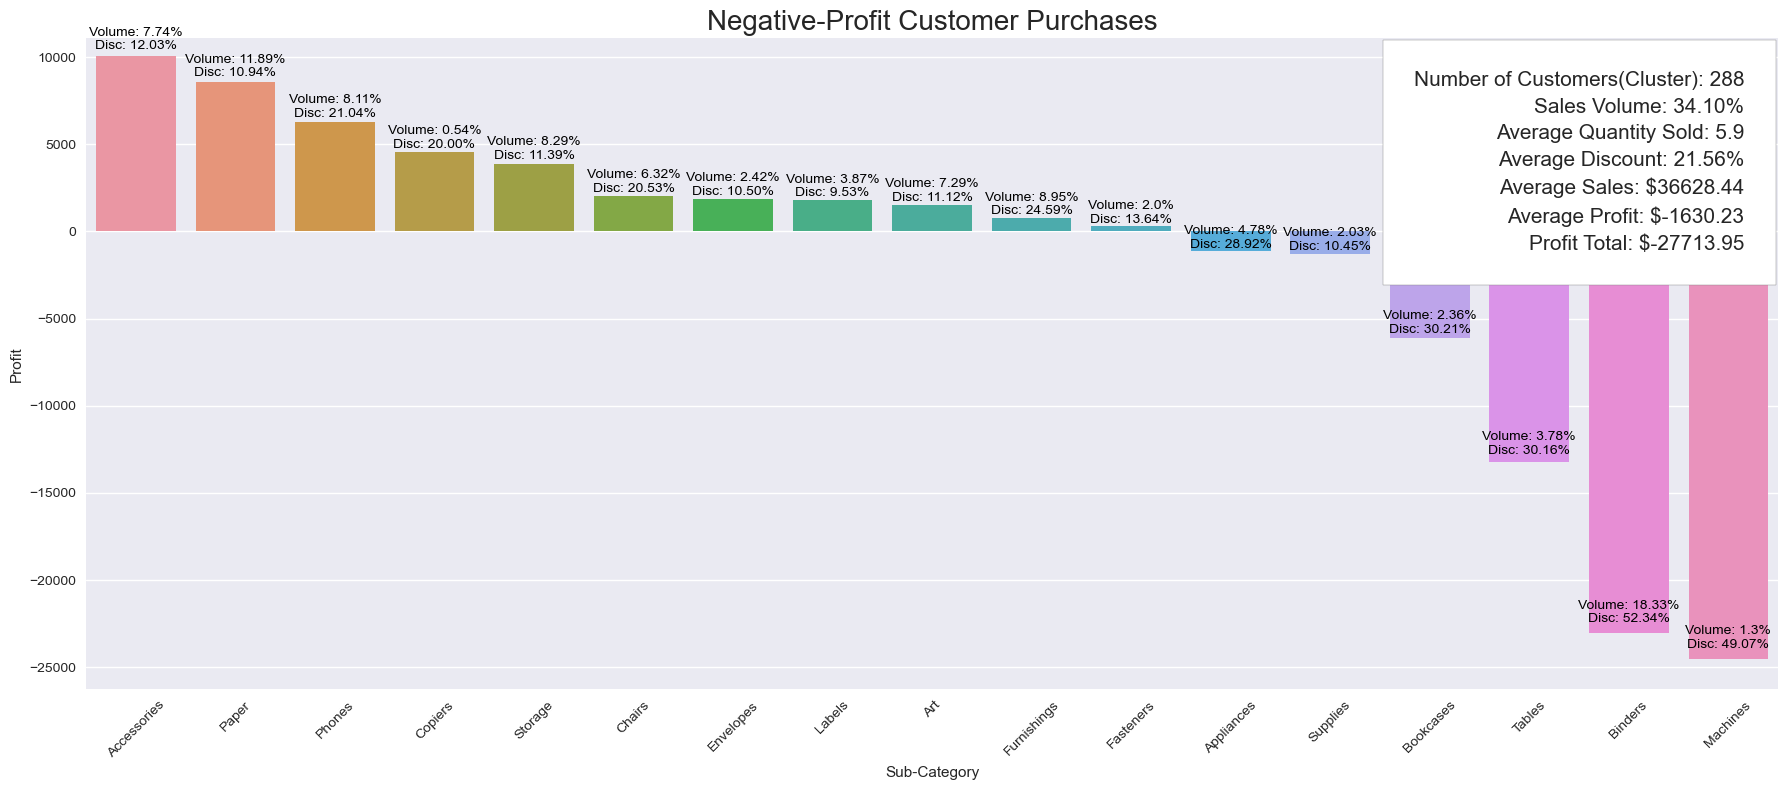

In [306]:
Negative_profit = df_with_cluster[df_with_cluster['Cluster'] == 1].groupby('Sub-Category').agg({
    'Profit': 'sum',
    'Sales': 'sum',
    'Discount': 'mean',
    'Order ID': 'count'
}).rename(columns={'Order ID' : 'Salescount'}).reset_index().sort_values(by='Profit', ascending=False)
plt.figure(figsize=(18, 8))

Sales_volume = len(df_with_cluster[df_with_cluster['Cluster'] == 1])
Negative_profit['Sales_volume'] = (Negative_profit['Salescount'] / Sales_volume * 100).round(2)


ax = sns.barplot(data=Negative_profit, x='Sub-Category', y='Profit')


for i, bar in enumerate(ax.patches):     
    Sales_pct = Negative_profit.iloc[i]['Sales_volume']
    discount = Negative_profit.iloc[i]['Discount']

    text = f'Volume: {Sales_pct}%\nDisc: {discount:.2%}'

    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.02 * abs(height)),  
        text,
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )



# Crear "recuadro" con medias del DataFrame
mean_quantity = Negative_profit['Sales_volume'].mean()
mean_discount = Negative_profit['Discount'].mean()
mean_sales = Negative_profit['Sales'].mean()
mean_profit = Negative_profit['Profit'].mean()
n_customers = df_with_cluster[df_with_cluster['Cluster'] == 1]['Customer ID'].nunique()
sum_profit = df_with_cluster[df_with_cluster['Cluster'] == 1]['Profit'].sum()
sum_sales = df_with_cluster[df_with_cluster['Cluster'] == 1]['Sales'].sum()
sales_volume = len(df_with_cluster[df_with_cluster['Cluster'] == 1]) / len(df) *100

info_text = (
    f"Number of Customers(Cluster): {n_customers}\n"
    f"Sales Volume: {sales_volume:.2f}%\n"
    f"Average Quantity Sold: {mean_quantity:.1f}\n"
    f"Average Discount: {mean_discount:.2%}\n"
    f"Average Sales: ${mean_sales:.2f}\n"
    f"Average Profit: ${mean_profit:.2f}\n"
    f"Profit Total: ${sum_profit:.2f}"
)

# Añadir recuadro en la esquina superior derecha
plt.text(
    x=0.98, y=0.95,
    s=info_text,
    transform=ax.transAxes,
    fontsize=15,
    verticalalignment='top',
    horizontalalignment='right',
    linespacing=1.5,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=1.5')
)


plt.title('Negative-Profit Customer Purchases', fontsize = 20)
plt.xticks(rotation=45)
plt.ylim(top=Negative_profit['Profit'].max() * 1.10)

print("Unprofitable customers buy products with high discount and low profit like Machines, Binders, Tables and Bookcases .\nWhich have a discount of more than 30%")
plt.tight_layout()
plt.show()

### Cluster 2 - Base-Customers

The Average Customer buys products with a low discount and medium profit like Accesories, Phones and Paper


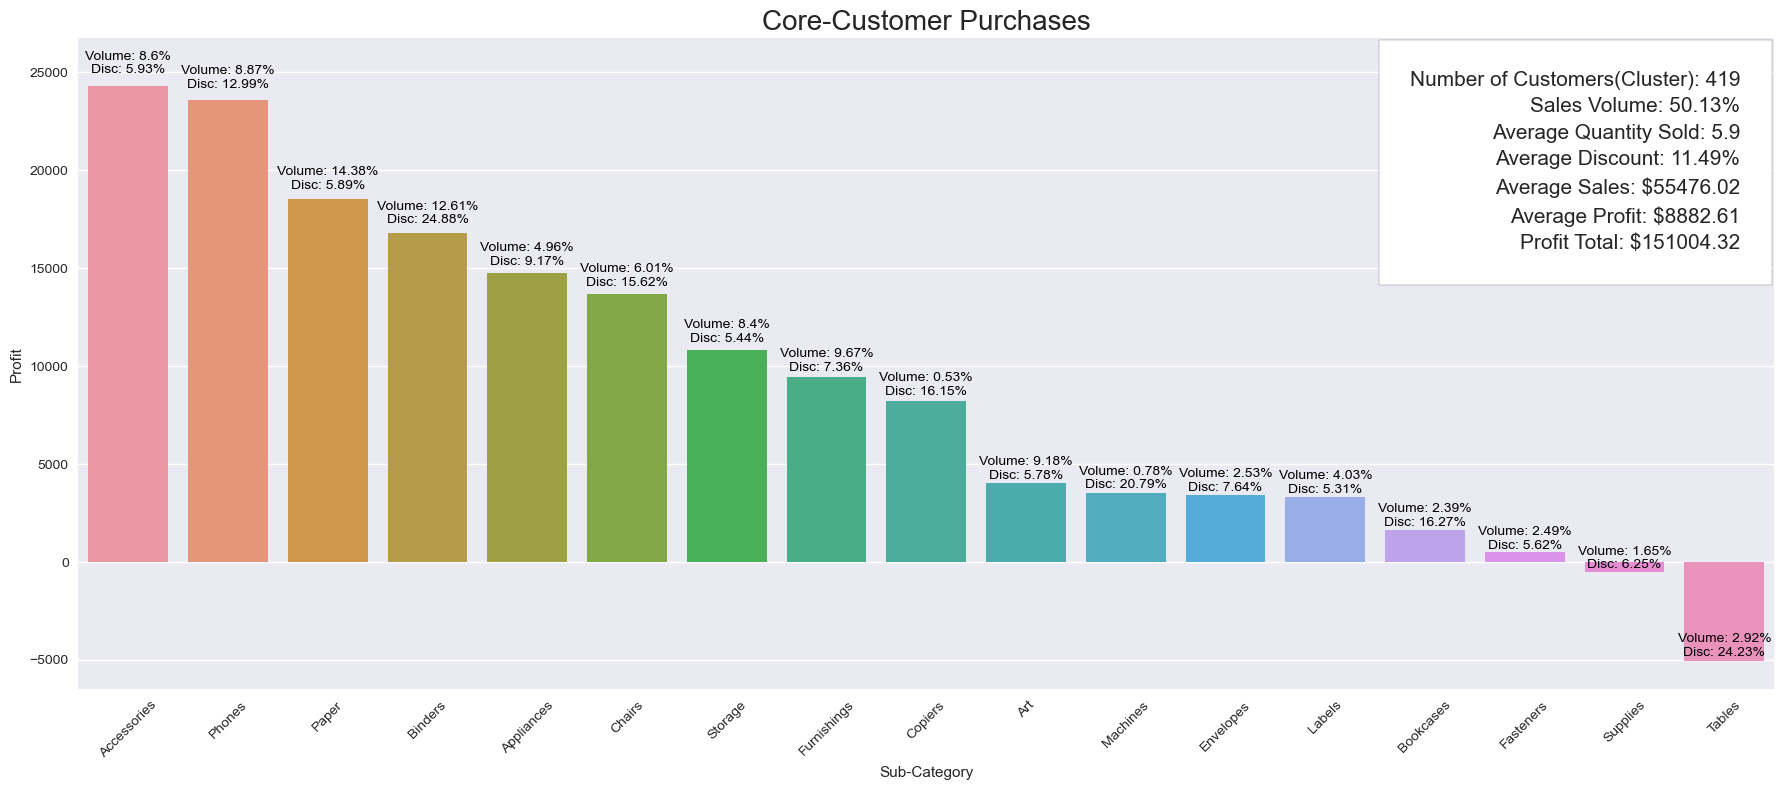

In [307]:
Core_customers = df_with_cluster[df_with_cluster['Cluster'] == 2].groupby('Sub-Category').agg({
    'Profit': 'sum',
    'Sales': 'sum',
    'Discount': 'mean',
    'Order ID': 'count'
}).rename(columns={'Order ID' : 'Salescount'}).reset_index().sort_values(by='Profit', ascending=False)
plt.figure(figsize=(18, 8))

Sales_volume = len(df_with_cluster[df_with_cluster['Cluster'] == 2])
Core_customers['Sales_volume'] = (Core_customers['Salescount'] / Sales_volume * 100).round(2)


ax = sns.barplot(data=Core_customers, x='Sub-Category', y='Profit')


for i, bar in enumerate(ax.patches):     
    Sales_pct = Core_customers.iloc[i]['Sales_volume']
    discount = Core_customers.iloc[i]['Discount']

    text = f'Volume: {Sales_pct}%\nDisc: {discount:.2%}'

    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.02 * abs(height)),  
        text,
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )



# Crear "recuadro" con medias del DataFrame
mean_quantity = Core_customers['Sales_volume'].mean()
mean_discount = Core_customers['Discount'].mean()
mean_sales = Core_customers['Sales'].mean()
mean_profit = Core_customers['Profit'].mean()
n_customers = df_with_cluster[df_with_cluster['Cluster'] == 2]['Customer ID'].nunique()
sum_profit = df_with_cluster[df_with_cluster['Cluster'] == 2]['Profit'].sum()
sum_sales = df_with_cluster[df_with_cluster['Cluster'] == 2]['Sales'].sum()
sales_volume = len(df_with_cluster[df_with_cluster['Cluster'] == 2]) / len(df) *100

info_text = (
    f"Number of Customers(Cluster): {n_customers}\n"
    f"Sales Volume: {sales_volume:.2f}%\n"
    f"Average Quantity Sold: {mean_quantity:.1f}\n"
    f"Average Discount: {mean_discount:.2%}\n"
    f"Average Sales: ${mean_sales:.2f}\n"
    f"Average Profit: ${mean_profit:.2f}\n"
    f"Profit Total: ${sum_profit:.2f}"
)

# Añadir recuadro en la esquina superior derecha
plt.text(
    x=0.98, y=0.95,
    s=info_text,
    transform=ax.transAxes,
    fontsize=15,
    verticalalignment='top',
    horizontalalignment='right',
    linespacing=1.5,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=1.5')
)


plt.title('Core-Customer Purchases', fontsize = 20)
plt.xticks(rotation=45)
plt.ylim(top=Core_customers['Profit'].max() * 1.10)

print("The Average Customer buys products with a low discount and medium profit like Accesories, Phones and Paper")
plt.tight_layout()
plt.show()

## 4.State-Level Profit Margin Validation

In [195]:

state_margin = df.groupby('State').agg({
    'Profit': 'sum',
    'Sales': 'sum',
    'Discount': 'mean',
    'Quantity': 'sum',
    'Row ID' : 'count'
}).rename(columns = {'Row ID' : 'Sales Volume'}).reset_index().sort_values(by='Profit', ascending=False)

state_margin['Profit Margin'] = state_margin['Profit'] / state_margin['Sales']
state_margin['%_of_Total_Quantity'] = state_margin['Quantity'] / state_margin['Quantity'].sum() * 100

# porcentaje de registros (filas) que pertenecen a cada estado en el dataset 
state_counts = df['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Row_count']
total_rows = len(df)
state_counts['%_of_Total_Records'] = (state_counts['Row_count'] / total_rows) * 100
state_counts['%_of_Total_Records'] = state_counts['%_of_Total_Records'].round(2)
state_counts.drop(columns=['Row_count'], inplace=True)
# merge the state_counts with state_margin
state_margin = state_margin.merge(state_counts, on='State', how='left')

state_margin = state_margin.rename(columns={
    'Profit': 'Total Profit',
    'Sales': 'Total Sales',
    'Discount': 'Average Discount',
    'Quantity': 'Total Quantity'
})
state_margin['Average Discount'] = round(state_margin['Average Discount'] * 100,1)
state_margin['Profit Margin'] = round(state_margin['Profit Margin'] * 100, 2)
state_margin

,State,Total Profit,Total Sales,Average Discount,Total Quantity,Sales Volume,Profit Margin,%_of_Total_Quantity,%_of_Total_Records
0,California,74669.2036,450567.5915,7.3000,7428,1942,16.5700,20.2128,20.0300
1,New York,73507.1252,309453.6330,5.5000,4129,1098,23.7500,11.2357,11.3300
2,Washington,32976.6151,136590.1720,6.4000,1809,487,24.1400,4.9226,5.0200
3,Michigan,24340.9487,75991.5840,0.7000,918,247,32.0300,2.4980,2.5500
4,Virginia,18461.0153,70309.0900,0.0000,865,215,26.2600,2.3538,2.2200
5,Indiana,18344.4375,53474.4300,0.0000,563,144,34.3100,1.5320,1.4900
6,Georgia,15933.6469,48296.3000,0.0000,691,180,32.9900,1.8803,1.8600
7,Kentucky,11199.6966,36591.7500,0.0000,523,139,30.6100,1.4232,1.4300
8,Minnesota,10823.1874,29863.1500,0.0000,331,89,36.2400,0.9007,0.9200
9,Delaware,9836.4242,27036.1690,0.7000,354,92,36.3800,0.9633,0.9500


### Z-Score 

In [310]:
# Margin analysis z-score
from scipy.stats import zscore

state_margin['Profit Margin Z-Score'] = zscore(state_margin['Profit Margin'])
# Filter states with a Z-Score greater than 1.5 or less than -1.5

high_margin_states = state_margin[state_margin['Profit Margin Z-Score'] > 1.5]
low_margin_states = state_margin[state_margin['Profit Margin Z-Score'] < -1.5]

print(f"Low Margin States:\n{low_margin_states[['State', 'Profit Margin', 'Profit Margin Z-Score']]}")

print()
print(f"High Margin States:\n{high_margin_states[['State', 'Profit Margin', 'Profit Margin Z-Score']]}")

Low Margin States:
             State  Profit Margin  Profit Margin Z-Score
41         Arizona       -10.0300                -1.6296
42       Tennessee       -17.3500                -2.0472
43        Colorado       -20.7400                -2.2406
44  North Carolina       -13.4800                -1.8264
45        Illinois       -15.2300                -1.9262
46    Pennsylvania       -13.4400                -1.8241
47            Ohio       -22.2800                -2.3285
48           Texas       -15.0600                -1.9165

High Margin States:
Empty DataFrame
Columns: [State, Profit Margin, Profit Margin Z-Score]
Index: []


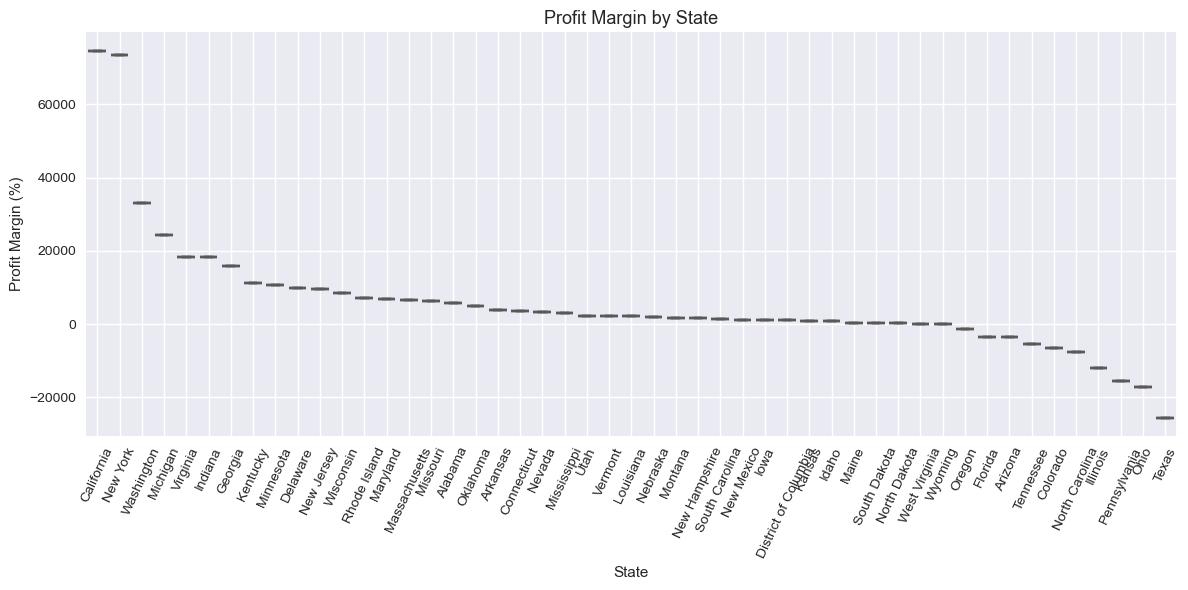

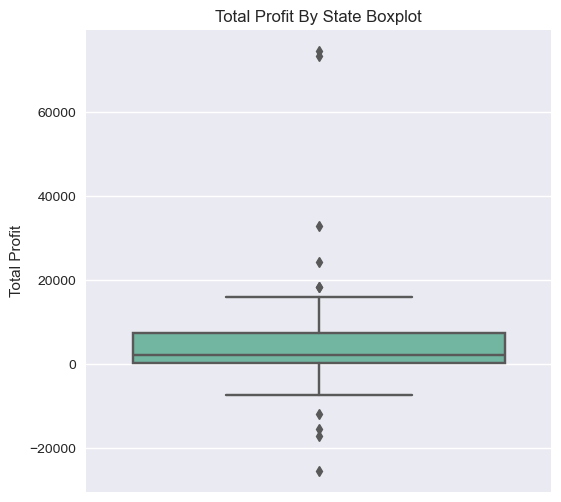

In [287]:
# boxplot of profit margin by state
plt.figure(figsize=(12, 6))
sns.boxplot(data=state_margin, x='State', y='Total Profit', palette='Set2')
plt.title('Profit Margin by State', fontsize=13)
plt.xlabel('State') 
plt.ylabel('Profit Margin (%)')
plt.xticks(rotation=65)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot( y=state_margin['Total Profit'], palette='Set2')
plt.title('Total Profit By State Boxplot')
plt.show()

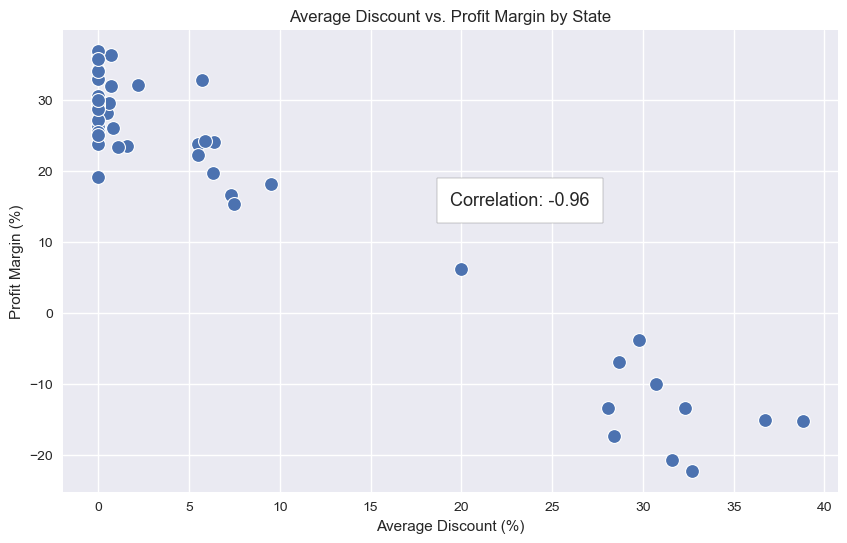

In [198]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=state_margin, x='Average Discount', y='Profit Margin', s=100)

plt.title('Average Discount vs. Profit Margin by State')
plt.xlabel('Average Discount (%)')
plt.ylabel('Profit Margin (%)')
plt.grid(True)

correlation = state_margin[['Average Discount', 'Profit Margin']].corr()
cor_text = f"Correlation: {correlation.iloc[0, 1]:.2f}"
plt.text(
    x=0.68, y=0.65,
    s=cor_text,
    transform=ax.transAxes,
    fontsize=13,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.75'))
plt.show()

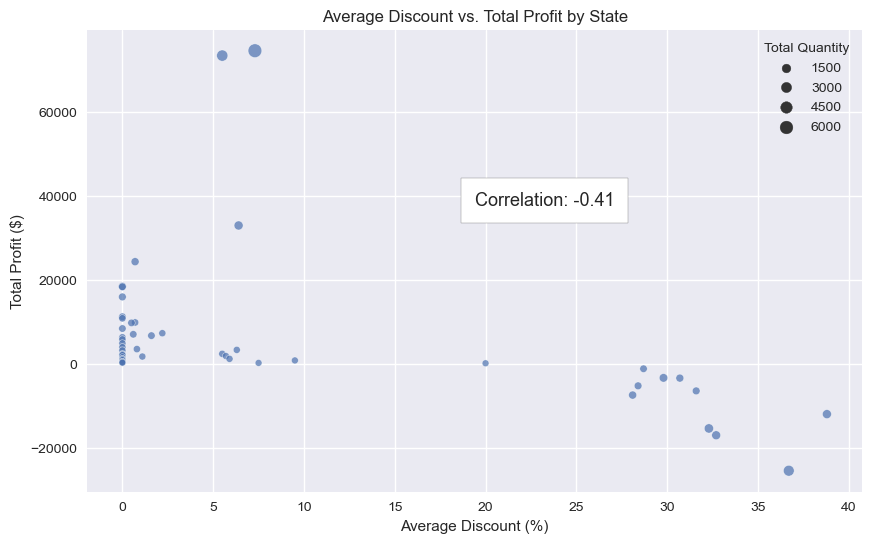

In [199]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=state_margin, x='Average Discount', y='Total Profit',size='Total Quantity', s=100, alpha=0.7)

correlation = state_margin[['Average Discount', 'Total Profit']].corr()
cor_text = f"Correlation: {correlation.iloc[0, 1]:.2f}"
plt.text(
    x=0.68, y=0.65,
    s=cor_text,
    transform=ax.transAxes,
    fontsize=13,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.75')
)
plt.title('Average Discount vs. Total Profit by State')
plt.xlabel('Average Discount (%)')
plt.ylabel('Total Profit ($)')
plt.grid(True)
plt.show()

In [200]:
## Maybe the lesser correlation between discount and profit margin and discount and total profit is because of the salesamount, so lets do a weighted correlation analysis
x = state_margin['Average Discount']
y = state_margin['Total Profit']
weights = state_margin['Sales Volume'] #we gave more importance (weight) to states that sold more items (higher Total Quantity).
# Step 2: Compute weighted means
weighted_mean_x = np.average(x, weights=weights)
weighted_mean_y = np.average(y, weights=weights)
# Compute weighted covariance and standard deviations
cov_xy = np.average((x - weighted_mean_x) * (y - weighted_mean_y), weights=weights)
std_x = np.sqrt(np.average((x - weighted_mean_x)**2, weights=weights))
std_y = np.sqrt(np.average((y - weighted_mean_y)**2, weights=weights))
# Compute weighted correlation
weighted_corr = cov_xy / (std_x * std_y)
print(f"Weighted Correlation On AVG Discount and Total Profit: {weighted_corr}")

Weighted Correlation On AVG Discount and Total Profit: -0.6627647882730904


### Product Category Loss Drivers

In [202]:
# Loss / No-Loss Contigency Table
df['Loss'] = df['Profit'] < 0
contingency_table = pd.crosstab(df['Sub-Category'], df['Loss'], margins=True, margins_name='Total')
contingency_table.columns = ['No Loss', 'Loss', 'Total']
contingency_table['Loss Percentage'] = (contingency_table['Loss'] / contingency_table['Total']) * 100
contingency_table = contingency_table.sort_values(by='Loss Percentage', ascending=False)
print(contingency_table)

              No Loss  Loss  Total  Loss Percentage
Sub-Category                                       
Tables            116   203    319          63.6364
Bookcases         119   109    228          47.8070
Binders           862   571   1433          39.8465
Machines           71    44    115          38.2609
Chairs            382   235    617          38.0875
Supplies          143    33    176          18.7500
Total            7886  1808   9694          18.6507
Storage           670   151    821          18.3922
Furnishings       754   156    910          17.1429
Phones            745   136    881          15.4370
Appliances        399    67    466          14.3777
Accessories       684    91    775          11.7419
Fasteners         200    12    212           5.6604
Labels            364     0    364           0.0000
Paper            1267     0   1267           0.0000
Envelopes         246     0    246           0.0000
Copiers            68     0     68           0.0000
Art         

In [204]:
# Perform Chi-Squared Test - we wanna check whether the observed counts differ significantly
#  from what we'd expect under the assumption that 
# losses are equally distributed across subcategories.
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(contingency_table[['No Loss', 'Loss']])

print(f"Chi-squared: {chi2}, P-value: {p}, Degrees of Freedom: {dof}\n\n Expected Frequencies: \n {expected}")

Chi-squared: 1849.7278045493213, P-value: 0.0, Degrees of Freedom: 17

 Expected Frequencies: 
 [[ 259.5042   59.4958]
 [ 185.4764   42.5236]
 [1165.7353  267.2647]
 [  93.5517   21.4483]
 [ 501.9251  115.0749]
 [ 143.1747   32.8253]
 [7886.     1808.    ]
 [ 667.8777  153.1223]
 [ 740.2785  169.7215]
 [ 716.6872  164.3128]
 [ 379.0877   86.9123]
 [ 630.457   144.543 ]
 [ 172.4605   39.5395]
 [ 296.1114   67.8886]
 [1030.6955  236.3045]
 [ 200.1192   45.8808]
 [  55.3175   12.6825]
 [ 647.5403  148.4597]]


In [215]:
# We can now compare observed and expected frequencies to find out which subcategories have significantly more or fewer losses than expected.

observed_losses = contingency_table['Loss']
expected_losses = expected[:,1]

difference = observed_losses - expected_losses
relative_difference = (difference / expected_losses) * 100

losses_insights = pd.DataFrame({
    'Observed Losses': observed_losses,
    'Expected Losses': expected_losses,
    'Difference': difference,
    'Relative Difference (%)': relative_difference
}).round(2).sort_values(by='Relative Difference (%)', ascending=False)

losses_insights


,Observed Losses,Expected Losses,Difference,Relative Difference (%)
Sub-Category,,,,
Tables,203,59.5000,143.5000,241.2000
Bookcases,109,42.5200,66.4800,156.3300
Binders,571,267.2600,303.7400,113.6500
Machines,44,21.4500,22.5500,105.1400
Chairs,235,115.0700,119.9300,104.2100
Supplies,33,32.8300,0.1700,0.5300
Total,1808,1808.0000,0.0000,0.0000
Storage,151,153.1200,-2.1200,-1.3900
Furnishings,156,169.7200,-13.7200,-8.0800


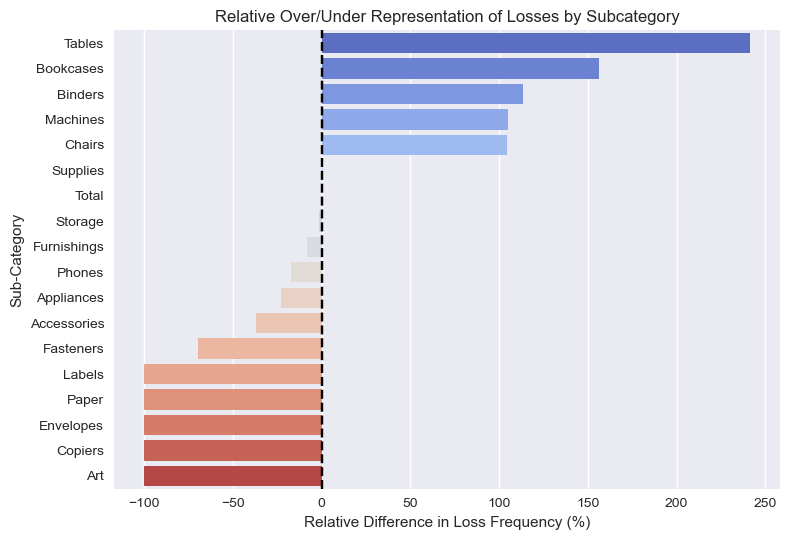

In [218]:
sns.barplot(data=losses_insights, x='Relative Difference (%)', y=losses_insights.index, palette='coolwarm')
plt.axvline(0, color='black', linestyle='--')
plt.title("Relative Over/Under Representation of Losses by Subcategory")
plt.xlabel("Relative Difference in Loss Frequency (%)")
plt.ylabel("Sub-Category")
plt.tight_layout()
plt.show()

The Chi-Squared test strongly suggests that product losses are not randomly or evenly distributed across sub-categories. Instead, they are significantly concentrated in specific sub-categories.

Since we can reject the null hypothesis that losses are equally spread, this implies that certain product types are more prone to losses than others — pointing to underlying structural issues.

Given this, we now shift our focus to analyzing the pricing and discounting patterns of these loss-driving sub-categories. These could be key contributors to the disproportionate loss rates observed.

### Further Analysis on Subcategories 

   Sub-Category  Total Profit  Total Sales  Average Discount  Total Quantity  \
0       Copiers    55617.8200  149528.0300           16.2000             234   
1        Phones    44447.8800  329753.0900           15.5000            3254   
2   Accessories    41936.6400  167380.3200            7.8000            2976   
3         Paper    32712.1700   75356.1200            7.5000            4811   
4       Binders    29983.0200  199905.7200           37.0000            5614   
5        Chairs    26590.1700  328449.1000           17.0000            2356   
6       Storage    21527.9100  216803.2100            7.5000            3065   
7    Appliances    18138.0100  107532.1600           16.7000            1729   
8   Furnishings    11588.6400   82752.2300           13.8000            3390   
9           Art     6527.7900   27118.7900            7.5000            3000   
10    Envelopes     6460.8700   15339.4900            8.1000             880   
11       Labels     5546.2500   12486.31

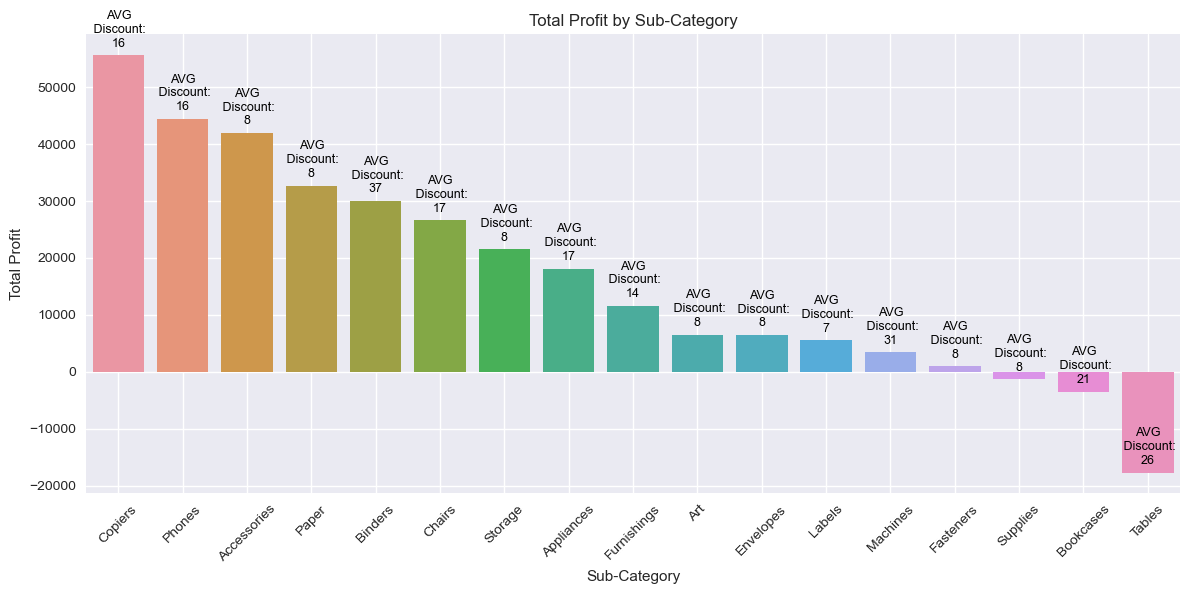

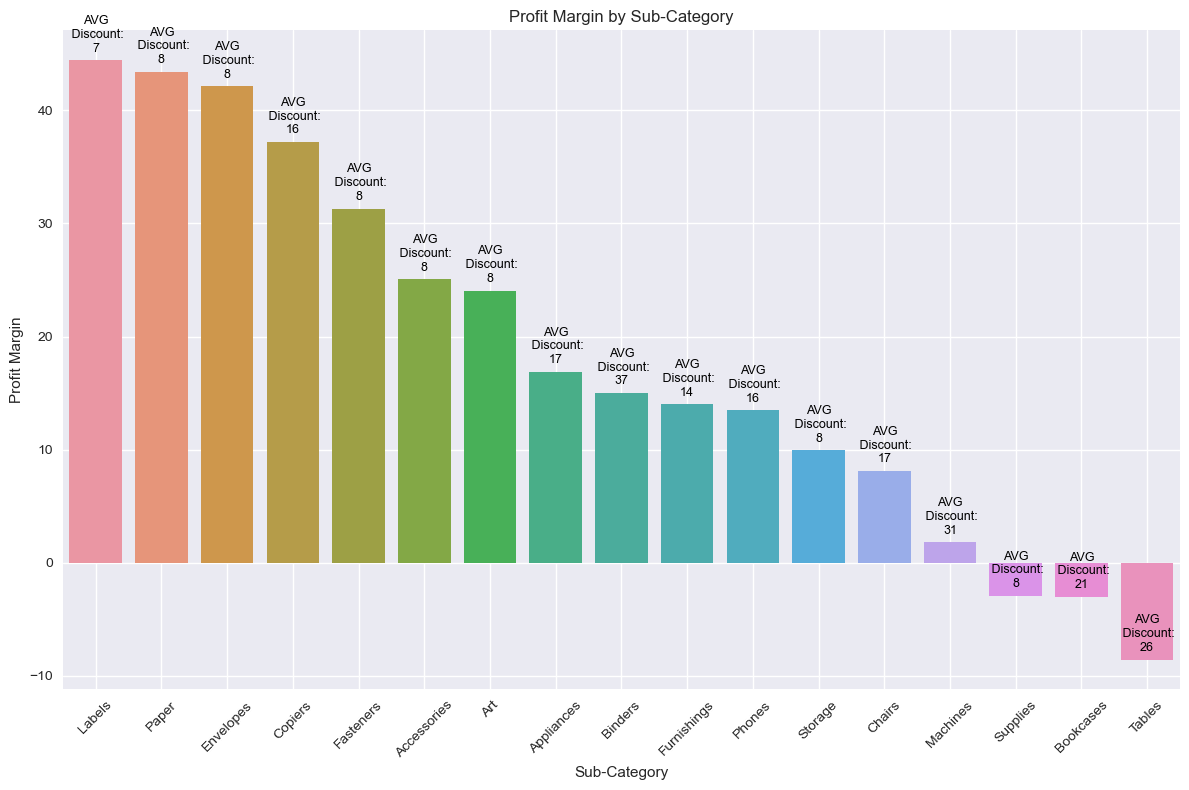

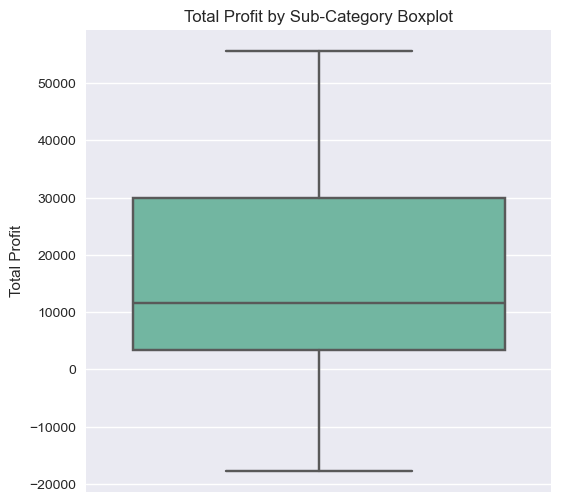

In [336]:
product_margin = df.groupby('Sub-Category').agg({
    'Profit': 'sum',
    'Sales': 'sum',
    'Discount': 'mean',
    'Quantity': 'sum'
}).reset_index().sort_values(by='Profit', ascending=False)
product_rows = df.groupby('Sub-Category').size().reset_index(name='Row_count')

product_margin['Profit Margin'] = product_margin['Profit'] / product_margin['Sales']
product_margin['%_of_Total_Quantity'] = product_margin['Quantity'] / product_margin['Quantity'].sum() * 100
product_margin['%_of_Total_Quantity'] = product_margin['%_of_Total_Quantity'].round(2)
product_margin['%_of_Total_Profit'] = product_margin['Profit'] / product_margin['Profit'].sum() * 100
product_margin['%_of_Total_Profit'] = product_margin['%_of_Total_Profit'].round(2)
product_margin['Average Profit'] = product_margin['Profit'] / product_rows['Row_count']

# sales total count
subcategory_counts = df['Sub-Category'].value_counts().reset_index()
subcategory_counts.columns = ['Sub-Category', 'Row_count']
total_rows = len(df)
subcategory_counts['%_of_Total_Records'] = (subcategory_counts['Row_count'] / total_rows) * 100
subcategory_counts['%_of_Total_Records'] = subcategory_counts['%_of_Total_Records'].round(2)
subcategory_counts.drop(columns=['Row_count'], inplace=True)

# merge the subcategory_counts with product_margin
product_margin = product_margin.merge(subcategory_counts, on='Sub-Category', how='left')

product_margin = product_margin.rename(columns={
    'Profit': 'Total Profit',
    'Sales': 'Total Sales',
    'Discount': 'Average Discount',
    'Quantity': 'Total Quantity'
})
product_margin['Average Discount'] = round(product_margin['Average Discount'] * 100, 1)
product_margin['Profit Margin'] = round(product_margin['Profit Margin'] * 100, 2)
print(product_margin.iloc[:, :-1].round(2))

plt.figure(figsize=(12, 6))
sns.barplot(data=product_margin, x='Sub-Category', y='Total Profit')
plt.title('Total Profit by Sub-Category')
plt.xlabel('Sub-Category')
plt.ylabel('Total Profit')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
for index, row in product_margin.iterrows():
    plt.text(
        x=index, 
        y=row['Total Profit'] + 1000,  # Adjust the height for text placement
        s=f"AVG\n Discount:\n{row['Average Discount']:.0f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
plt.show()

product_margin = product_margin.sort_values('Profit Margin', ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 8))
sns.barplot(data=product_margin, x='Sub-Category', y='Profit Margin')
plt.title('Profit Margin by Sub-Category')
plt.xlabel('Sub-Category')
plt.ylabel('Profit Margin')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

for i, row in product_margin.iterrows():
    plt.text(
        x=i, 
        y= row['Profit Margin'] + 0.5,  # Adjust the height for text placement
        s=f"AVG\n Discount:\n{row['Average Discount']:.0f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(y=product_margin['Total Profit'], palette='Set2')
plt.title('Total Profit by Sub-Category Boxplot')
plt.show()


#### Product Sub-Categories High vs Low Discount Levels

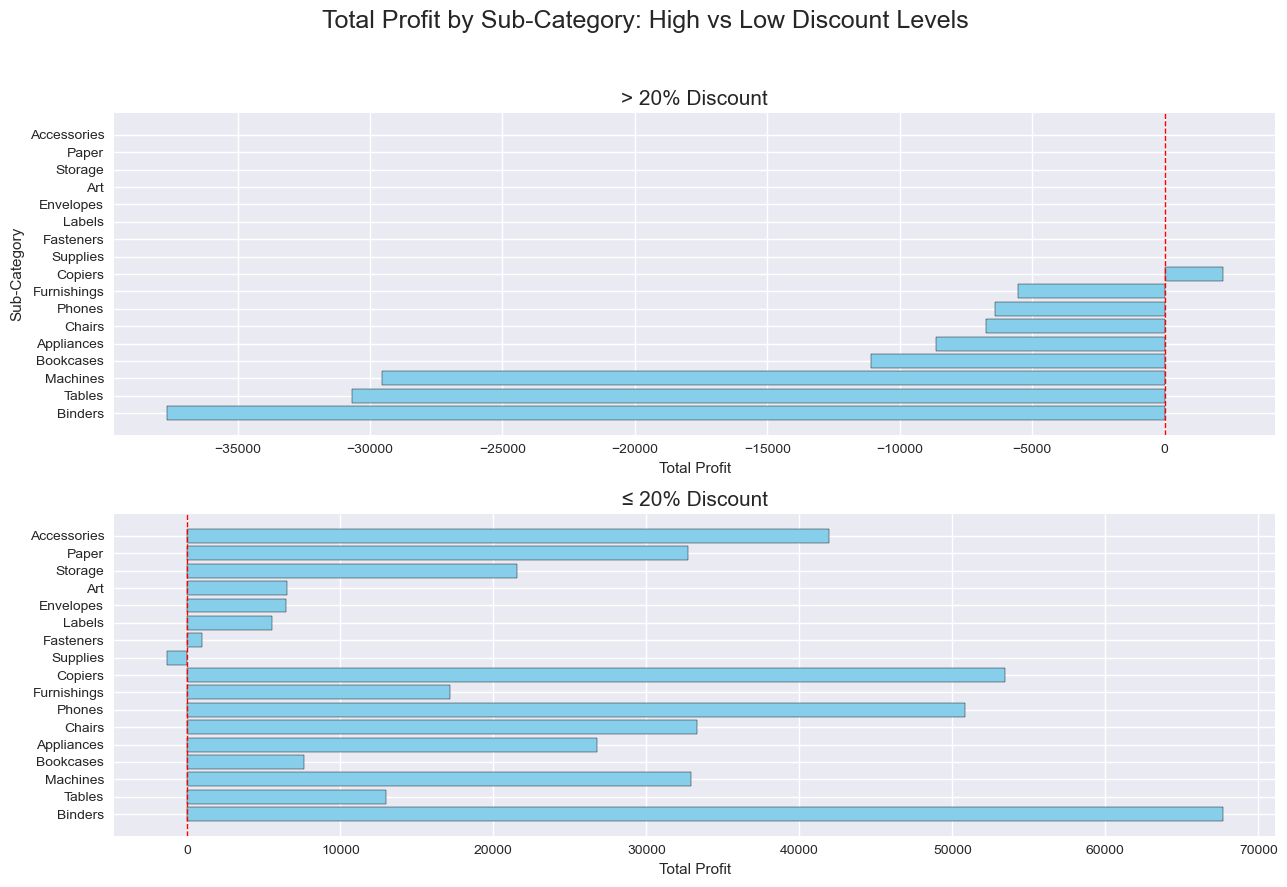

It’s clear that while total profit is generally positive, when we focus on products with discounts below 20%, nearly all subcategories show losses—except for Copiers.


In [267]:
# Create a new column to split the data
df['Discount Group'] = df['Discount'].apply(lambda x: '> 20% Discount' if x > 0.2 else '≤ 20% Discount')

# Calculate Profit Margin per Sub-Category within each group
subcat_margin = df.groupby(['Discount Group', 'Sub-Category']).agg({
    'Profit': 'sum',
    'Sales': 'sum'
}).reset_index()

# Plotting

discount_groups = subcat_margin['Discount Group'].unique()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 9), sharey=True)

discount_groups = subcat_margin['Discount Group'].unique()

for ax, group in zip(axes, discount_groups):
    data = subcat_margin[subcat_margin['Discount Group'] == group].sort_values(by='Profit', ascending=True)

    bars = ax.barh(data['Sub-Category'], data['Profit'], color='skyblue', edgecolor='black')

    # Add text labels on ba
    ax.set_title(group, fontsize=15)
    ax.set_xlabel('Total Profit')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

axes[0].set_ylabel('Sub-Category')
plt.suptitle('Total Profit by Sub-Category: High vs Low Discount Levels', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("It’s clear that while total profit is generally positive, when we focus on products with discounts below 20%, nearly all subcategories show losses—except for Copiers.")

Based on our analysis, we can confidently state the following:
- **Discounts tend to lower the profit margins:**
  - Discounts above 20% consistently generate negative profits (losses).
  - A clear negative correlation exists between Average Discount and Profit Margin across states.
- **Sales revenue variation is primarily driven by volume, not by unit profitability or pricing**
  
- **Customer segmentation reveals three distinct profiles:**
  - *High-Value Customers:* Buys high profit low discount products.
  - *Unprofitable Customers* Tend to buy highly discounted products that lead to losses in profit
  - *Average Customer:* Purchase moderately discounted items with average profit margins.
- **The states of Arizona, Tennessee, Colorado ,North Carolina, Illinois ,Pennsylvania ,Ohio and Texas have significantly lower profit margins compared to the national average.**
- **We can asume that certain product Subcategories are more prone to generating losses:**
  - *Most profitable subcategories (absolute profit):* Copiers, Phones, Accessories, Paper.
  - *Most profitable by margin:* Labels, Paper, Envelopes, Copiers.